1. Data Loading

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Input   1000 non-null   object
 1   Output  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None

Sample data:
                                               Input    Output
0  Applicant earns $34488 annually, has a credit ...  Approved
1  Applicant earns $59088 annually, has a credit ...  Rejected
2  Applicant earns $125907 annually, has a credit...  Rejected
3  Applicant earns $125066 annually, has a credit...  Rejected
4  Applicant earns $82196 annually, has a credit ...  Rejected


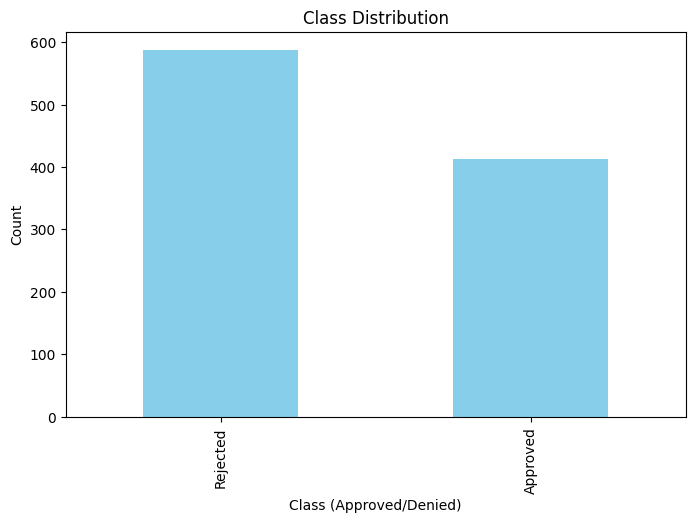

Training set size: 720
Validation set size: 80
Test set size: 200


In [4]:
# Install necessary libraries
# !pip install nltk keras gensim scikit-learn pandas matplotlib

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')

# Define the dataset path
dataset_path = '/content/drive/My Drive/nlp task2/Final_dataset.csv'  # Update if needed

# Load the dataset
data = pd.read_csv(dataset_path)

# Exploratory Data Analysis (EDA)
print("Dataset overview:")
print(data.info())  # Checking for missing values, data types
print("\nSample data:")
print(data.head())  # Display the first few rows

# Plot class distribution
plt.figure(figsize=(8, 5))
data['Output'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class (Approved/Denied)')
plt.ylabel('Count')
plt.show()

# Splitting data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Display dataset split details
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


2.Text Processing

In [11]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Function to clean and preprocess text
def preprocess_text(text):
    if isinstance(text, str):  # Ensure text is not NaN
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'\W', ' ', text)  # Remove special characters
        text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
        tokens = word_tokenize(text)  # Tokenize the text
        tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
        return ' '.join(tokens)
    else:
        return ''  # Return empty string if NaN

# Apply the preprocessing to the dataset
train_data['processed_text'] = train_data['Input'].apply(preprocess_text)
val_data['processed_text'] = val_data['Input'].apply(preprocess_text)
test_data['processed_text'] = test_data['Input'].apply(preprocess_text)

# Check the processed text
print(train_data[['Input', 'processed_text']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                 Input  \
940  Applicant earns $64805 annually, has a credit ...   
547  Applicant earns $31171 annually, has a credit ...   
900  Applicant earns $36149 annually, has a credit ...   
603  Applicant earns $119315 annually, has a credit...   
348  Applicant earns $74440 annually, has a credit ...   

                                        processed_text  
940  applicant earns 64805 annually credit score 65...  
547  applicant earns 31171 annually credit score 82...  
900  applicant earns 36149 annually credit score 54...  
603  applicant earns 119315 annually credit score 7...  
348  applicant earns 74440 annually credit score 65...  


3. Text Embedding

In [12]:
# Install required libraries
!pip install gensim scikit-learn

# Import necessary libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import numpy as np

# Ensure processed_text column exists
if 'processed_text' not in train_data.columns:
    raise ValueError("Error: 'processed_text' column is missing. Run preprocessing step first.")

# --- Bag of Words (BoW) ---
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow = bow_vectorizer.transform(test_data['processed_text']).toarray()

# --- TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# --- FastText (Word Embeddings) ---
# Tokenize the text data
train_tokens = train_data['processed_text'].apply(str.split)
val_tokens = val_data['processed_text'].apply(str.split)
test_tokens = test_data['processed_text'].apply(str.split)

# Train FastText model
fasttext_model = gensim.models.FastText(sentences=train_tokens, vector_size=100, window=5, min_count=5, workers=4)

# Convert sentences to vector representations
def get_fasttext_vectors(model, sentences):
    return np.array([np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(100)], axis=0) for words in sentences])

X_train_fasttext = get_fasttext_vectors(fasttext_model, train_tokens)
X_val_fasttext = get_fasttext_vectors(fasttext_model, val_tokens)
X_test_fasttext = get_fasttext_vectors(fasttext_model, test_tokens)

print("Embedding completed for BoW, TF-IDF, and FastText.")


Embedding completed for BoW, TF-IDF, and FastText.


4. Model Training with Different Architectures

In [14]:
# Install required libraries
!pip install tensorflow keras scikit-learn

# Import necessary libraries
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Bidirectional, Embedding, Flatten, Dropout , GRU, GlobalAveragePooling1D
from sklearn.preprocessing import LabelEncoder

# Encode labels (convert categorical labels to numerical)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['Output'])
val_labels = label_encoder.transform(val_data['Output'])
test_labels = label_encoder.transform(test_data['Output'])

# Define input dimension for embeddings
input_dim = X_train_tfidf.shape[1]  # Based on TF-IDF vocabulary size

# Define a CNN Model
def cnn_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define an LSTM Model
def lstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a BiLSTM Model
def bilstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a CNN-BiLSTM Model
def cnn_bilstm_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a GRU Model (Similar to LSTM but computationally faster)
def gru_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a Simple MLP Model (Baseline Model)
def mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a Transformer-Based Model (Uses Attention Mechanism)
def transformer_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=input_dim))
    model.add(GlobalAveragePooling1D())  # Simulating a simple Transformer-based model
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train CNN Model
cnn = cnn_model(input_dim)
cnn.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

# Train LSTM Model
lstm = lstm_model(input_dim)
lstm.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

# Train BiLSTM Model
bilstm = bilstm_model(input_dim)
bilstm.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

# Train CNN-BiLSTM Model
cnn_bilstm = cnn_bilstm_model(input_dim)
cnn_bilstm.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

# Train GRU Model
GRU = gru_model(input_dim)
GRU.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

# Train MLP Model
MLP = mlp_model(input_dim)
MLP.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

# Train Transformer Model
Transformer = transformer_model(input_dim)
Transformer.fit(X_train_tfidf, train_labels, validation_data=(X_val_tfidf, val_labels), epochs=5, batch_size=64)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 798ms/step - accuracy: 0.5154 - loss: 0.7988 - val_accuracy: 0.6125 - val_loss: 0.6679
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 827ms/step - accuracy: 0.5878 - loss: 0.6872 - val_accuracy: 0.6125 - val_loss: 0.6694
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 657ms/step - accuracy: 0.6009 - loss: 0.6740 - val_accuracy: 0.6125 - val_loss: 0.6707
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 688ms/step - accuracy: 0.5996 - loss: 0.6759 - val_accuracy: 0.6125 - val_loss: 0.6684
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 823ms/step - accuracy: 0.5893 - loss: 0.6798 - val_accuracy: 0.6125 - val_loss: 0.6715
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.5404 - loss: 0.6847 - val_accuracy: 0.6125 - val_loss: 0.6702
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.6015 - loss: 0.6738 - val_accuracy: 0.6125 - val_loss: 0.6701
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.5935 - loss: 0.6776 - val_accuracy: 0.6125 - val_loss: 0.6

5. Comparative Analysis of Models

In [41]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Convert labels from text ('Approved', 'Rejected') to numbers (1, 0)
label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(test_data['Output'])  # Encode labels

# Predict on test data
y_pred_cnn = cnn.predict(X_test_bow).round()
y_pred_lstm = lstm.predict(X_test_bow).round()
y_pred_bilstm = bilstm.predict(X_test_bow).round()
y_pred_cnn_bilstm = cnn_bilstm.predict(X_test_bow).round()
y_pred_gru = GRU.predict(X_test_bow).round()
y_pred_mlp = MLP.predict(X_test_bow).round()
y_pred_transformer = Transformer.predict(X_test_bow).round()

# Evaluate all models
models = {
    "CNN": y_pred_cnn,
    "LSTM": y_pred_lstm,
    "BiLSTM": y_pred_bilstm,
    "CNN-BiLSTM": y_pred_cnn_bilstm,
    "GRU": y_pred_gru,
    "MLP": y_pred_mlp,
    "Transformer": y_pred_transformer
}

best_model = None
best_accuracy = 0

for model_name, y_pred in models.items():
    acc = accuracy_score(test_labels, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}")
    print(f"{model_name} Classification Report:\n", classification_report(test_labels, y_pred,zero_division=1))
    print("-" * 50)

    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model_name




7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 855ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
CNN Accuracy: 0.5350
CNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        93
           1       0.54      1.00      0.70       107

    accuracy                           0.54       200
   macro avg       0.77      0.50      0.35       200
weighted avg       0.75      0.54      0.37       200

--------------------------------------------------
LSTM Accuracy: 0.5350
LSTM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00        93
           1       0.54      1.00      0.70       107

    accuracy                           0.54       200
   macro avg       0.77      0.50

6. Saving the best Model

In [30]:
# Save the best model
if best_model == "CNN":
    cnn.save('best_text_classification_model.h5')
elif best_model == "LSTM":
    lstm.save('best_text_classification_model.h5')
elif best_model == "BiLSTM":
    bilstm.save('best_text_classification_model.h5')
elif best_model == "CNN-BiLSTM":
    cnn_bilstm.save('best_text_classification_model.h5')
elif best_model == "GRU":
    GRU.save('best_text_classification_model.h5')
elif best_model == "MLP":
    MLP.save('best_text_classification_model.h5')
elif best_model == "Transformer":
    Transformer.save('best_text_classification_model.h5')

print(f"Best model ({best_model}) saved as 'best_text_classification_model.h5'")

import keras.saving
keras.saving.save_model(best_model, 'best_text_classification_model.keras')


Best model (<Sequential name=sequential_5, built=True>) saved as 'best_text_classification_model.h5'


7. Prediction on Real World Input

In [40]:
# Load the saved model
from keras.models import load_model
model = load_model('best_text_classification_model.h5')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Real-world input (sample from dataset)
new_text = "Applicant earns $137739 annually, has a credit score of 785, no outstanding loan, 0 missed payments in the last year, employment status: Self-employed, Owns home, and 1 recent credit inquiries."
processed_text = preprocess_text(new_text)
input_data = bow_vectorizer.transform([processed_text]).toarray()

# Predicting the class of new text
predicted_class = model.predict(input_data).round()[0][0]
output_label = "Accepted" if predicted_class == 0 else "Rejected"

print(f"Predicted Class: {output_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Class: Accepted
